In [1]:
# import standard modules and DCTR
import sys
import numpy as np
import math
import tensorflow as tf

# import DCTR
# path_to_DCTR = './' # modify as needed
import DCTR

# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load data

In [3]:
data_dir = './Data'

In [7]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0

# every particle has arguments: 
# [pt, rapidity, phi, mass, eta, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4  , 5, 6  , 7, 8    ]


X0_test = []
# POWHEG hvq
# args: filePath, i=number of particles to load
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/14TeV/converted_lhe.npz', i=3)[:int(1e7)] # i=number of particles to load 3: top, anti-top, tt-pair; loading with 10 of 30 million samples
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))


X1_test = []
# MiNNLO
X1_test = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_14TeV_NLO/converted_lhe.npz', i=3) # more or less 10 million samples
print('MiNNLO     X1_test.shape: '+str(X1_test.shape))



POWHEG hvq X0_test.shape: (10000000, 3, 9)
MiNNLO     X1_test.shape: (9553938, 3, 9)


In [8]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0

X0_nrm = []
X1_nrm = []

# POWHEG hvq
X0_nrm = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/14TeV/normed_lhe.npz', i=3)[:int(1e7)]
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))

# MiNNLO
X1_nrm = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_14TeV_NLO/normed_lhe.npz', i=3)
print('MiNNLO all particles X1.shape: '+str(np.array(X1_nrm).shape))



POWHEG hvq all particles X0.shape: (10000000, 3, 9)
MiNNLO all particles X1.shape: (9553938, 3, 9)


In [9]:
# delete eta (pseudorpaidity) because neural network was too good at classifiying
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


In [10]:
# get normalized event generator weights
X0_nrm_wgt = X0_nrm[:, 0, 6].copy() # would be arg 7, but we removed eta above
X1_nrm_wgt = X1_nrm[:, 0, 6].copy()


# prep data for training

In [9]:
# prep arrays for the neural network

# prep_arrays() necessary args:
# X0, X1
# prep_arrays() default args:
# val=0.15, shuffle=True, use_class_weights=False

# strips theta parameter from datasets and creates Y classifier arrays
# strips wgts from datasets and creates wgt arrays | if use_class_weights==True: -> give over represented dataset smaller weights 
# splits arrays into training and validation datasets accroding to val
# splits arrays into training and validation datasets accroding to val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)



# train DCTR neural network

In [56]:
# setup neural positive reweigher
# default setup_nn() args:
# input_dim=7, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
# loss = 'cce', foc_gamma=2, dropout=0.0, l2_reg=0.0, learning_rate=0.001,
# patience=10, use_scheduler=True, monitor='val_loss', mode='min', 
# savePath=currentPath, saveLabel='DCTR_training', summary=False):

# suppots 'mse', 'focal' and 'cce' losses. default 'cce' is used if string isn't either 'mse' or 'focal'
# returns neural network and callbacks

dctr, callbacks = DCTR.setup_nn(input_dim=6, patience=10, saveLabel='DCTR_training')


Epoch 1/150
318/319 [============================>.] - ETA: 0s - loss: 0.5606 - acc: 0.7544
Epoch 1: val_loss improved from inf to 0.55487, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [==============================] - 26s 75ms/step - loss: 0.5606 - acc: 0.7544 - val_loss: 0.5549 - val_acc: 0.7562 - lr: 0.0010
Epoch 2/150
318/319 [============================>.] - ETA: 0s - loss: 0.5511 - acc: 0.7560
Epoch 2: val_loss improved from 0.55487 to 0.54470, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [==============================] - 24s 74ms/step - loss: 0.5511 - acc: 0.7560 - val_loss: 0.5447 - val_acc: 0.7562 - lr: 0.0010
Epoch 3/150
318/319 [============================>.] - ETA: 0s - loss: 0.5446 - acc: 0.7560
Epoch 3: val_loss improved from 0.54470 to 0.54179, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [===

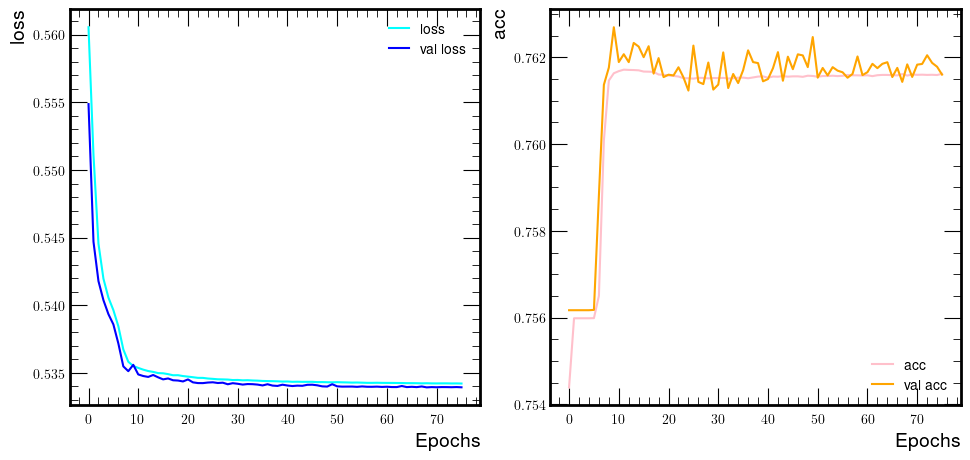

In [57]:
# train neural network
# train() necessary args:
# dctr, callbacks, X_train, Y_train, X_val, Y_val
# train() default args:
# wgt_train=1.0, wgt_val=1.0, epochs=80, batch_size=8192, savePath=currentPath, saveLabel='DCTR_training'):

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*32, saveLabel='DCTR_training')


# load training and predict weights

In [12]:
# load training
dctr, _ = DCTR.setup_nn(input_dim=6, patience=10, saveLabel='DCTR_training')
dctr.load_weights('BachelorThesis_BAK/DCTR_training.h5')

# get reweighting weights
with tf.device('/gpu:0'): # sometimes gave me errors when done on GPU
    weights = DCTR.predict_weights(dctr, X0_nrm[...,:-2], batch_size=8192*16) # [...,:-2] b/c X0_nrm contains event weights and identifier, that are separated from training data in prep data step


2024-03-20 10:38:58.576306: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 720000000 exceeds 10% of free system memory.
2024-03-20 10:38:58.851385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 720000000 exceeds 10% of free system memory.


77/77 [==============================] - 2s 18ms/step


# check and plot DCTR predictions

In [13]:
X0_delta_phi = DCTR.delta_phi(X0_test)
X1_delta_phi = DCTR.delta_phi(X1_test)


NNLO: mean: 2.646, std: 0.664, max/min: 3.1415926443988056/2.0450538809058116e-06 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 2.636, std: 0.665, max/min: 3.1415926534573932/1.6969452891757442e-06 
 Mean Absolute Error 13217.666612068462 
 Mean Relative Error 0.021900091948340413 
 reduced chi square of 341.47808129116726 with p 0.0 
 compared to NNLO
NLO reweighted: mean: 2.646, std: 0.664, max/min: 3.1415926534573932/1.6969452891757442e-06 
 Mean Absolute Error 886.6028645833334 
 Mean Relative Error 0.0066832988522946835 
 reduced chi square of 2.6101383639334235 with p 4.8532503645206116e-06 
 compared to NNLO


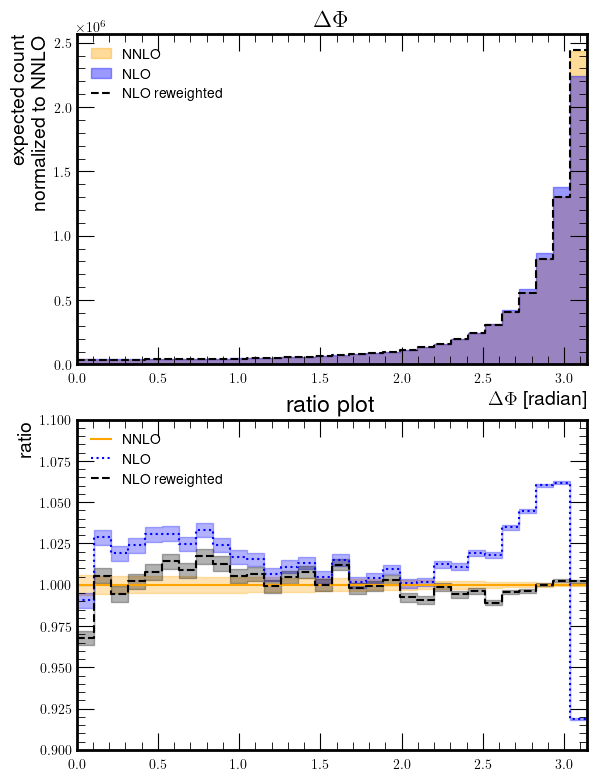

([0.0, 13217.666612068462, 886.6028645833334],
 [0.0, 341.47808129116726, 2.6101383639334235],
 [1.0, 0.0, 4.8532503645206116e-06])

In [15]:
args_phi = [(X1_delta_phi, X1_nrm_wgt, 'NNLO'),
            (X0_delta_phi, X0_nrm_wgt, 'NLO'),
            (X0_delta_phi, weights, 'NLO reweighted')]

DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = 31)


NNLO: mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 64.392, std: 74.987, max/min: 2764.1800602190083/0.16964772325734567 
 Mean Absolute Error 14154.87738825714 
 Mean Relative Error 0.17510712595308842 
 reduced chi square of 434.7508898052043 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 61.779, std: 72.904, max/min: 2764.1800602190083/0.16964772325734567 
 Mean Absolute Error 775.7778553682215 
 Mean Relative Error 0.03706326335668564 
 reduced chi square of 2.166878147004511 with p 0.00011656195204556845 
 compared to NNLO


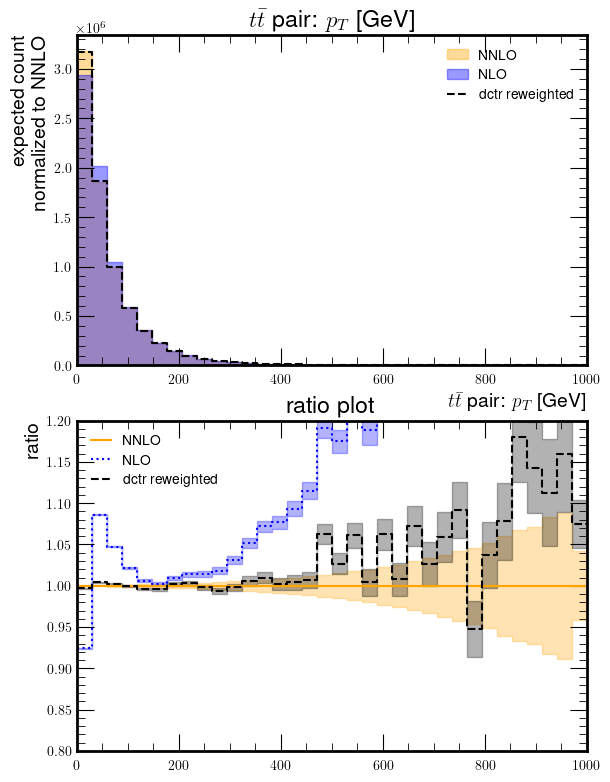

NNLO: mean: 0.000, std: 1.032, max/min: 3.5697566023272644/-3.547147542892114 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.001, std: 1.055, max/min: 3.6291263291592433/-3.6554655461346397 
 Mean Absolute Error 5132.161207296925 
 Mean Relative Error 0.16740416155154383 
 reduced chi square of 122.67343107549601 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.005, std: 1.035, max/min: 3.6291263291592433/-3.6554655461346397 
 Mean Absolute Error 1343.5041130851296 
 Mean Relative Error 0.07332904636859894 
 reduced chi square of 6.160243946423896 with p 2.099599960035934e-26 
 compared to NNLO


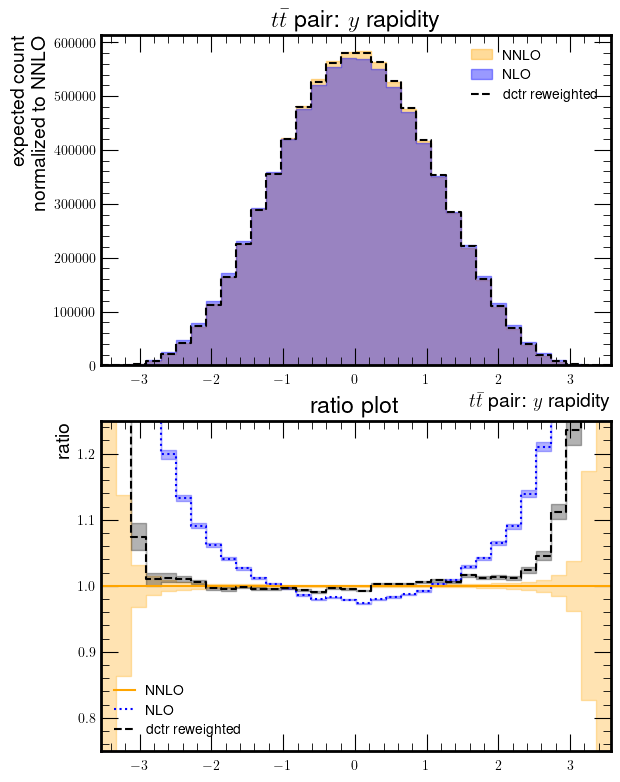

NNLO: mean: 523.184, std: 178.057, max/min: 5626.682794956003/322.9727283915917 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 525.521, std: 180.858, max/min: 5550.947420673375/212.02312740510408 
 Mean Absolute Error 3631.218460648564 
 Mean Relative Error 0.028274237142234905 
 reduced chi square of 43.98283513091671 with p 2.892636906435772e-284 
 compared to NNLO
dctr reweighted: mean: 523.713, std: 178.798, max/min: 5550.947420673375/212.02312740510408 
 Mean Absolute Error 609.9346421185662 
 Mean Relative Error 0.010824497789144516 
 reduced chi square of 1.3836643379116005 with p 0.07019432450943036 
 compared to NNLO


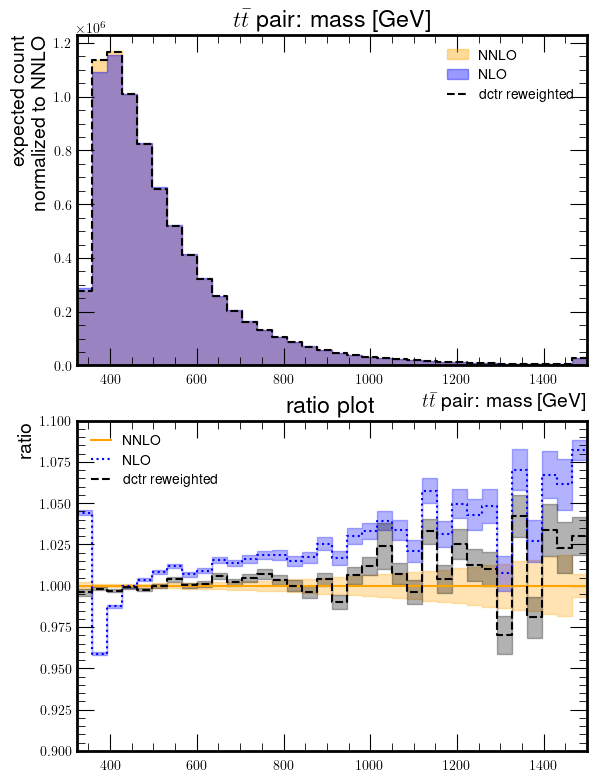

NNLO: mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.001, std: 3.301, max/min: 9.36400701562471/-9.319436413406622 
 Mean Absolute Error 11395.640332107707 
 Mean Relative Error 0.785108904643157 
 reduced chi square of 732.0597153128444 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.015, std: 3.408, max/min: 9.36400701562471/-9.319436413406622 
 Mean Absolute Error 1533.8582907284008 
 Mean Relative Error 0.1311614066362381 
 reduced chi square of 7.682259524127473 with p 7.709684256485424e-36 
 compared to NNLO


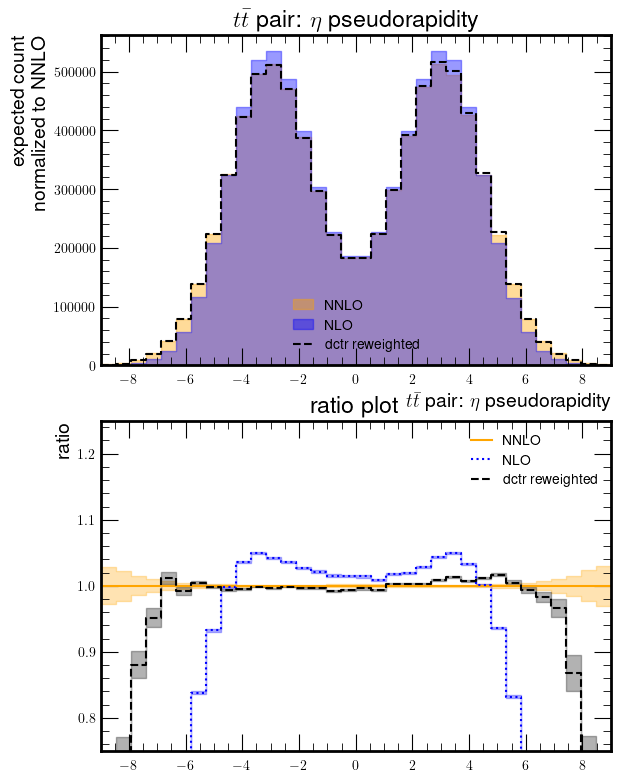

NNLO: mean: 862.694, std: 503.370, max/min: 6492.5814801/329.6132055 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 886.199, std: 537.293, max/min: 6920.394397/223.7331504 
 Mean Absolute Error 6163.541857869957 
 Mean Relative Error 0.06682025532232676 
 reduced chi square of 177.73081367387033 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 866.068, std: 508.420, max/min: 6920.394397/223.7331504 
 Mean Absolute Error 1058.2811351102941 
 Mean Relative Error 0.009703326039016247 
 reduced chi square of 4.268495057371813 with p 2.776375473877154e-15 
 compared to NNLO


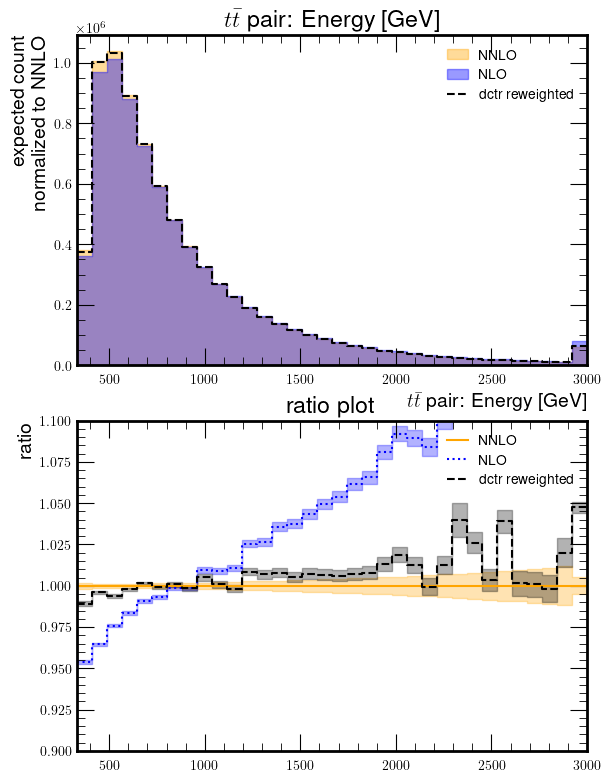

NNLO: mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 123.923, std: 81.902, max/min: 2115.296396072295/0.03527095323799307 
 Mean Absolute Error 6717.874220472592 
 Mean Relative Error 0.10833873947403512 
 reduced chi square of 128.9321705003223 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 121.170, std: 80.227, max/min: 2115.296396072295/0.03527095323799307 
 Mean Absolute Error 476.3751003040987 
 Mean Relative Error 0.028620591387152672 
 reduced chi square of 1.2278079759514817 with p 0.1726112996970029 
 compared to NNLO


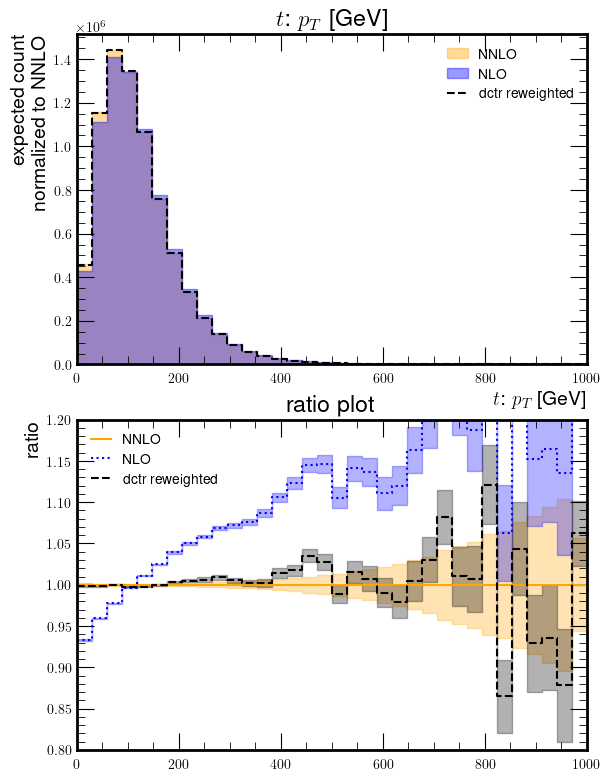

NNLO: mean: 0.000, std: 1.214, max/min: 4.194517128782431/-4.141641811983429 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.001, std: 1.232, max/min: 4.093050884104104/-4.061396777442782 
 Mean Absolute Error 3214.550859702932 
 Mean Relative Error 0.1877034179525113 
 reduced chi square of 56.4229484521981 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.005, std: 1.217, max/min: 4.093050884104104/-4.061396777442782 
 Mean Absolute Error 1071.2135304422939 
 Mean Relative Error 0.18556524813175201 
 reduced chi square of 3.9396433671860844 with p 1.8628661543170252e-13 
 compared to NNLO


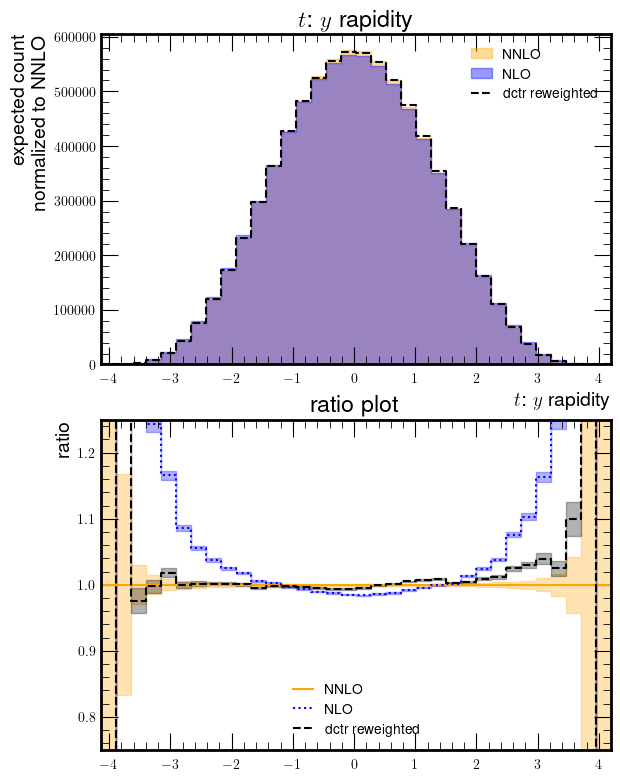

NNLO: mean: 172.341, std: 2.602, max/min: 185.5999802308967/159.40000608638425 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 171.945, std: 6.955, max/min: 243.94750289312123/80.42225936275699 
 Mean Absolute Error 15617.718288739201 
 Mean Relative Error 0.26057031275846837 
 reduced chi square of 5552.146759017539 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 172.343, std: 2.598, max/min: 243.94750289312123/80.42225936275699 
 Mean Absolute Error 505.99474379595586 
 Mean Relative Error 0.00985773652791977 
 reduced chi square of 1.515027532989747 with p 0.029243424295215037 
 compared to NNLO


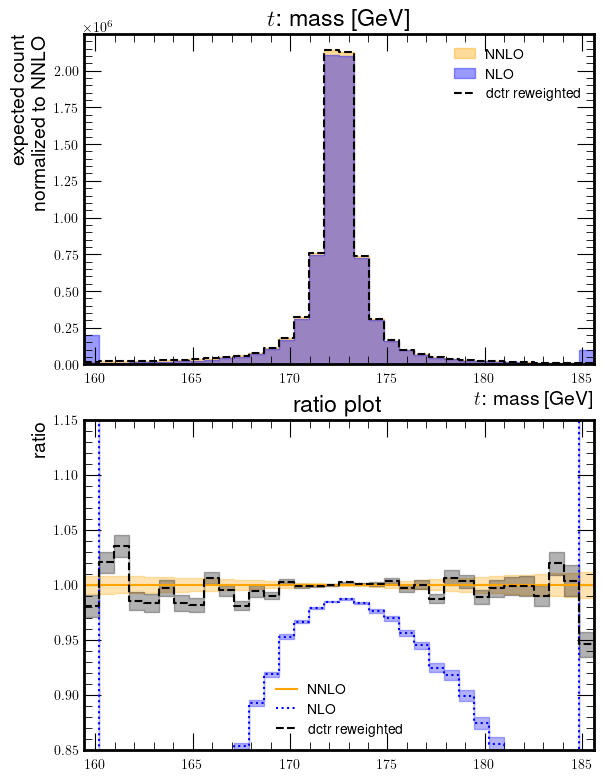

NNLO: mean: 0.001, std: 1.884, max/min: 9.769814493793154/-10.18823770968854 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.001, std: 1.885, max/min: 9.540437841309883/-10.44415574755628 
 Mean Absolute Error 560.2050433269468 
 Mean Relative Error 0.08125601951556535 
 reduced chi square of 1.7508515812689096 with p 0.004842186631464683 
 compared to NNLO
dctr reweighted: mean: 0.007, std: 1.888, max/min: 9.540437841309883/-10.44415574755628 
 Mean Absolute Error 1117.381268304937 
 Mean Relative Error 0.10655985027551651 
 reduced chi square of 3.251218565245765 with p 8.68090842550391e-10 
 compared to NNLO


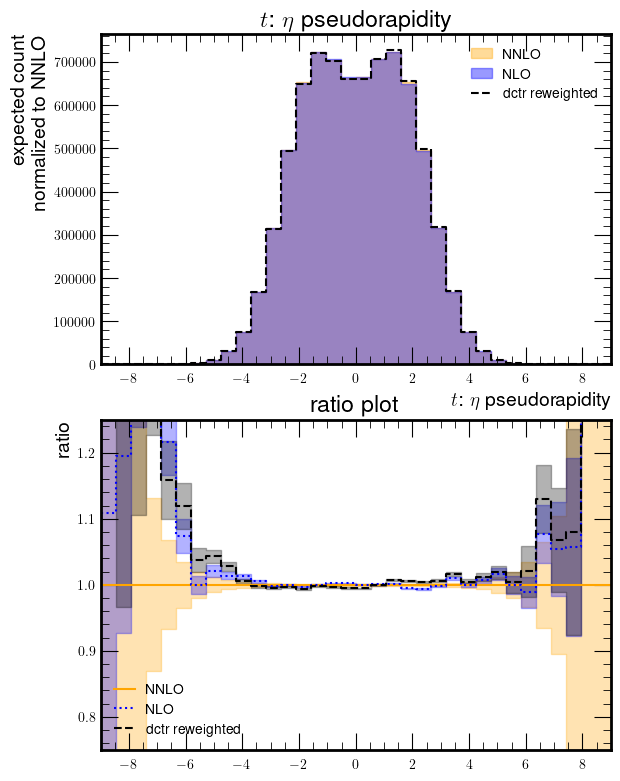

NNLO: mean: 432.960, std: 333.470, max/min: 5996.224969/159.6472363 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 444.263, std: 352.304, max/min: 6027.376185/84.47637093 
 Mean Absolute Error 5023.477710026132 
 Mean Relative Error 0.056131689636005164 
 reduced chi square of 98.58928101194697 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 434.651, std: 336.264, max/min: 6027.376185/84.47637093 
 Mean Absolute Error 893.6451487821691 
 Mean Relative Error 0.008839812129735947 
 reduced chi square of 2.5949719990646 with p 1.468211565057656e-06 
 compared to NNLO


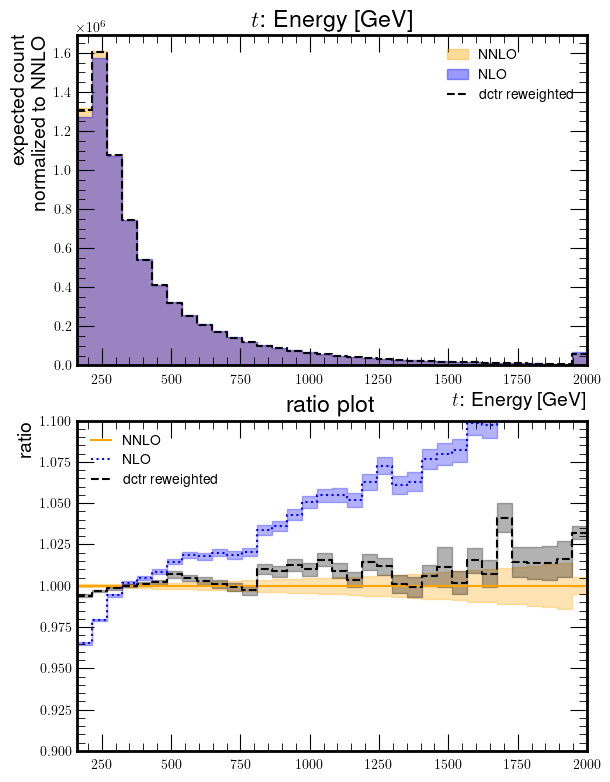

In [16]:
args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights, 'dctr reweighted')]

arg_indices = [0, 1, 3, 4, 5]
part_indices = [0, 1]
div = 31

mae_all = []
chi2_all = []
p_all = []

for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        ratio_ylim = [0.75, 1.25]
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
                ratio_ylim = [0.90, 1.10]
            else:
                start = None
                stop = None
                ratio_ylim = [0.85, 1.15]
        elif arg_index == 4:  # pseudorapidity
            start = -9
            stop = 9
        elif arg_index == 5: # energy
            ratio_ylim = [0.9, 1.10]
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            ratio_ylim = [0.8, 1.2]
            start = 0
            stop = 1000
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args, arg_index=arg_index, part_index=part_index, start = start, stop = stop, ratio_ylim = ratio_ylim)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)


In [19]:
# mean stats over all histograms

mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print('[NNLO, NLO, NLR rwgt]')
print(f'MAE  mean: {mae_mean}\n')
print(f'chi2 mean: {chi2_mean}\n')
print(f'p    mean: {p_mean}\n')


[NNLO, NLO, NLR rwgt]
MAE  mean: [   0.         7161.12653684  938.5965828 ]

chi2 mean: [  0.         734.90396956   3.41902105]

p    mean: [1.00000000e+00 4.84218663e-04 2.72167080e-02]



NNLO: mean: 172.341, std: 2.602, max/min: 185.5999802308967/159.40000608638425 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 171.945, std: 6.955, max/min: 243.94750289312123/80.42225936275699 
 Mean Absolute Error 17053.123937146018 
 Mean Relative Error 0.26155658085597355 
 reduced chi square of 5970.419551342972 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 172.343, std: 2.598, max/min: 243.94750289312123/80.42225936275699 
 Mean Absolute Error 544.6594947076613 
 Mean Relative Error 0.00983438827097416 
 reduced chi square of 1.4979099844653725 with p 0.03912335415771776 
 compared to NNLO


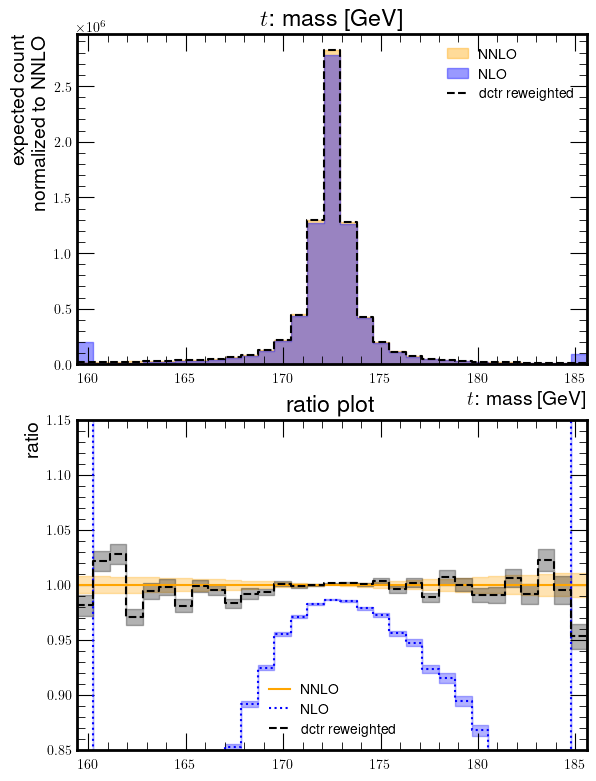

([0.0, 17053.123937146018, 544.6594947076613],
 [0.0, 5970.419551342972, 1.4979099844653725],
 [1.0, 0.0, 0.03912335415771776])

In [20]:
# redo mass with better binning

start = None
stop = None
div = 32
ratio_ylim = [0.85, 1.15]

args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights, 'dctr reweighted')]

DCTR.plot_ratio(args, arg_index=3, part_index=1, start = start, stop = stop, div=div, ratio_ylim = ratio_ylim)
